In [172]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
import os
os.chdir('/content/drive/My Drive/HAR')
! ls -l

total 2714
-rw------- 1 root root  305776 Sep 19 14:56 best.hdf5
-rw------- 1 root root 1277283 Sep 19 09:48 HAR_EDA.ipynb
-rw------- 1 root root  130898 Sep 19 15:25 HAR_LSTM.ipynb
-rw------- 1 root root  303733 Sep 19 09:51 HAR_PREDICTION_MODELS.ipynb
-rw------- 1 root root  143922 Aug 23  2018 t-sne_perp_10_iter_1000.png
-rw------- 1 root root  135463 Aug 23  2018 t-sne_perp_20_iter_1000.png
-rw------- 1 root root  167195 Aug 23  2018 t-sne_perp_2_iter_1000.png
-rw------- 1 root root  150494 Aug 23  2018 t-sne_perp_50_iter_1000.png
-rw------- 1 root root  157603 Aug 23  2018 t-sne_perp_5_iter_1000.png
drwx------ 5 root root    4096 Sep 18 19:03 UCI_HAR_Dataset


In [175]:
import pandas as pd
import numpy as np
import seaborn as sns

In [232]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [177]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [178]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [179]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).values
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [180]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

In [181]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [182]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [183]:
# Configuring a session
session_conf =  tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [184]:
# Import Keras
from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session

<function tensorflow.python.keras.backend.set_session>

In [185]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [186]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [187]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [188]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [191]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [192]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

In [199]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(8, input_shape=(timesteps, input_dim),return_sequences= True))
# Adding a dropout layer
model.add(Dropout(0.7))
model.add(BatchNormalization())

model.add(LSTM(16))
model.add(Dropout(0.7))
model.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 128, 8)            576       
_________________________________________________________________
dropout_43 (Dropout)         (None, 128, 8)            0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 8)            32        
_________________________________________________________________
lstm_51 (LSTM)               (None, 16)                1600      
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16)                64        
_________________________________________________________________
dense_23 (Dense)             (None, 6)               

In [200]:
filepath = "model.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')

In [201]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_split=0.33,
          epochs=epochs,
          callbacks=[checkpoint])

Epoch 1/30
308/308 [==============================] - ETA: 0s - loss: 1.6768 - accuracy: 0.3163
Epoch 00001: val_accuracy improved from -inf to 0.54223, saving model to model.hdf5
308/308 [==============================] - 31s 99ms/step - loss: 1.6768 - accuracy: 0.3163 - val_loss: 1.3072 - val_accuracy: 0.5422
Epoch 2/30
308/308 [==============================] - ETA: 0s - loss: 1.2968 - accuracy: 0.4861
Epoch 00002: val_accuracy improved from 0.54223 to 0.62176, saving model to model.hdf5
308/308 [==============================] - 31s 99ms/step - loss: 1.2968 - accuracy: 0.4861 - val_loss: 0.9919 - val_accuracy: 0.6218
Epoch 3/30
308/308 [==============================] - ETA: 0s - loss: 1.1214 - accuracy: 0.5283
Epoch 00003: val_accuracy improved from 0.62176 to 0.63988, saving model to model.hdf5
308/308 [==============================] - 30s 99ms/step - loss: 1.1214 - accuracy: 0.5283 - val_loss: 0.8946 - val_accuracy: 0.6399
Epoch 4/30
308/308 [==============================] - E

In [233]:
# Confusion Matrix

print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_UPSTAIRS
True                                                                    
LAYING                 521        0         0        0                16
SITTING                  1      427        60        1                 2
STANDING                 0      128       403        1                 0
WALKING                  2        1       111      351                31
WALKING_DOWNSTAIRS       1        0         0       18               401
WALKING_UPSTAIRS         4        0         5      101               361


93/93 [==============================] - 2s 19ms/step - loss: 0.7626 - accuracy: 0.7000


----------------------------------------------------------------------------------------------------


model accuracy is 0.7000339031219482


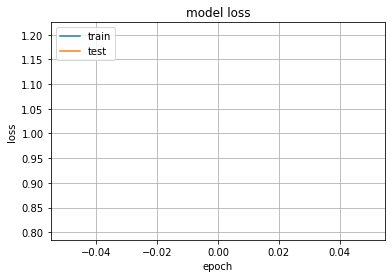

In [236]:
score = model.evaluate(X_test, Y_test)
print('\n')
print('-'*100)
print('\n')
print(f'model accuracy is {score[1]}')


import matplotlib.pyplot  as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [120]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(16, input_shape=(timesteps, input_dim),return_sequences= True))
# Adding a dropout layer
model.add(Dropout(0.3))

model2.add(LSTM(32))
model2.add(Dropout(0.7))

# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='sigmoid'))
model2.summary()

# Compiling the model
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 128, 16)           1664      
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
Total params: 8,134
Trainable params: 8,134
Non-trainable params: 0
_________________________________________________________________


In [121]:
# Training the model
history2=model2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Epoch 1/30
460/460 [==============================] - 47s 101ms/step - loss: 1.3230 - accuracy: 0.4544 - val_loss: 1.0300 - val_accuracy: 0.5745
Epoch 2/30
460/460 [==============================] - 46s 100ms/step - loss: 0.9668 - accuracy: 0.5934 - val_loss: 0.8456 - val_accuracy: 0.6661
Epoch 3/30
460/460 [==============================] - 46s 100ms/step - loss: 0.8053 - accuracy: 0.6620 - val_loss: 0.9324 - val_accuracy: 0.6376
Epoch 4/30
460/460 [==============================] - 46s 99ms/step - loss: 0.7820 - accuracy: 0.6748 - val_loss: 0.7659 - val_accuracy: 0.6851
Epoch 5/30
460/460 [==============================] - 46s 99ms/step - loss: 0.7270 - accuracy: 0.6982 - val_loss: 0.6875 - val_accuracy: 0.6973
Epoch 6/30
460/460 [==============================] - 46s 100ms/step - loss: 0.6719 - accuracy: 0.7274 - val_loss: 0.6823 - val_accuracy: 0.7201
Epoch 7/30
460/460 [==============================] - 48s 103ms/step - loss: 0.5972 - accuracy: 0.7497 - val_loss: 0.7390 - val_accu

In [122]:
# Confusion Matrix
print(confusion_matrix(Y_test, model2.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  0      393  ...                   2                 3
STANDING                 0       52  ...                   0                 0
WALKING                  0        0  ...                   0                16
WALKING_DOWNSTAIRS       0        0  ...                 397                22
WALKING_UPSTAIRS         0        0  ...                   5               424

[6 rows x 6 columns]


In [123]:
score = model2.evaluate(X_test, Y_test)
print('\n')
print('-'*100)
print('\n')
print(f'model accuracy is {score[1]}')

93/93 [==============================] - 2s 20ms/step - loss: 0.4637 - accuracy: 0.9091


----------------------------------------------------------------------------------------------------


model accuracy is 0.9090600609779358


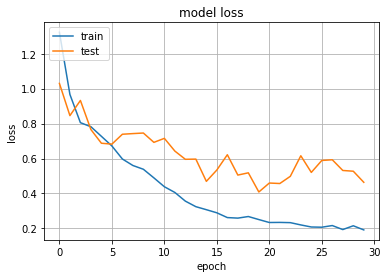

In [124]:
import matplotlib.pyplot  as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [226]:
# Initiliazing the sequential model
model3 = Sequential()
# Configuring the parameters
model3.add(LSTM(32, input_shape=(timesteps, input_dim),return_sequences= True))
# Adding a dropout layer
model3.add(Dropout(0.7))
model3.add(BatchNormalization())

model3.add(LSTM(64))
model3.add(Dropout(0.7))
model3.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes, activation='sigmoid'))

model3.summary()

# Compiling the model
model3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_51 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 32)           128       
_________________________________________________________________
lstm_59 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dropout_52 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
_________________________________________________________________
dense_27 (Dense)             (None, 6)               

In [237]:
# Training the model
history3=model3.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_split=0.33,
          epochs=epochs)

Epoch 1/30
308/308 [==============================] - ETA: 0s - loss: 0.8143 - accuracy: 0.6370
Epoch 00001: val_accuracy did not improve from 0.67079
308/308 [==============================] - 39s 125ms/step - loss: 0.8143 - accuracy: 0.6370 - val_loss: 0.9845 - val_accuracy: 0.6296
Epoch 2/30
308/308 [==============================] - ETA: 0s - loss: 0.7174 - accuracy: 0.6662
Epoch 00002: val_accuracy improved from 0.67079 to 0.77585, saving model to model3.hdf5
308/308 [==============================] - 38s 123ms/step - loss: 0.7174 - accuracy: 0.6662 - val_loss: 0.6756 - val_accuracy: 0.7759
Epoch 3/30
308/308 [==============================] - ETA: 0s - loss: 0.6431 - accuracy: 0.7062
Epoch 00003: val_accuracy did not improve from 0.77585
308/308 [==============================] - 40s 129ms/step - loss: 0.6431 - accuracy: 0.7062 - val_loss: 0.7072 - val_accuracy: 0.7425
Epoch 4/30
308/308 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7773
Epoch 00004: val

In [243]:
# Confusion Matrix
print(confusion_matrix(Y_test, model3.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 517        0  ...                   0                13
SITTING                  2      451  ...                   0                 0
STANDING                 0      125  ...                   0                 0
WALKING                  0        1  ...                   1                 1
WALKING_DOWNSTAIRS       0        0  ...                 388                21
WALKING_UPSTAIRS         0        0  ...                   0               471

[6 rows x 6 columns]


93/93 [==============================] - 3s 34ms/step - loss: 0.3121 - accuracy: 0.9223


----------------------------------------------------------------------------------------------------


model accuracy is 0.9222938418388367


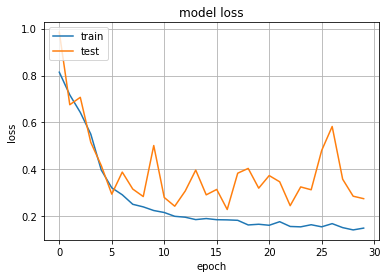

In [245]:
score = model3.evaluate(X_test, Y_test)
print('\n')
print('-'*100)
print('\n')
print(f'model accuracy is {score[1]}')

import matplotlib.pyplot  as plt
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [267]:
# Initiliazing the sequential model
model4 = Sequential()
# Configuring the parameters
model4.add(LSTM(8, input_shape=(timesteps, input_dim),return_sequences= True))
# Adding a dropout layer
model4.add(Dropout(0.3))
model4.add(BatchNormalization())

model4.add(LSTM(16,return_sequences= True))
model4.add(Dropout(0.5))
model4.add(BatchNormalization())

model4.add(LSTM(32))
model4.add(Dropout(0.7))
model4.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='sigmoid'))
model4.summary()

# Compiling the model
model4.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 128, 8)            576       
_________________________________________________________________
dropout_65 (Dropout)         (None, 128, 8)            0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 8)            32        
_________________________________________________________________
lstm_76 (LSTM)               (None, 128, 16)           1600      
_________________________________________________________________
dropout_66 (Dropout)         (None, 128, 16)           0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 128, 16)           64        
_________________________________________________________________
lstm_77 (LSTM)               (None, 32)              

In [268]:
filepath = "model4.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')

# Training the model
history4=model4.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_split=0.33,
          epochs=epochs,
          callbacks=[checkpoint])

Epoch 1/30
308/308 [==============================] - ETA: 0s - loss: 1.4209 - accuracy: 0.4386
Epoch 00001: val_accuracy improved from -inf to 0.61846, saving model to model4.hdf5
308/308 [==============================] - 51s 166ms/step - loss: 1.4209 - accuracy: 0.4386 - val_loss: 1.0668 - val_accuracy: 0.6185
Epoch 2/30
308/308 [==============================] - ETA: 0s - loss: 1.0284 - accuracy: 0.5523
Epoch 00002: val_accuracy improved from 0.61846 to 0.62835, saving model to model4.hdf5
308/308 [==============================] - 49s 158ms/step - loss: 1.0284 - accuracy: 0.5523 - val_loss: 0.8194 - val_accuracy: 0.6283
Epoch 3/30
308/308 [==============================] - ETA: 0s - loss: 0.8877 - accuracy: 0.6234
Epoch 00003: val_accuracy improved from 0.62835 to 0.63947, saving model to model4.hdf5
308/308 [==============================] - 49s 159ms/step - loss: 0.8877 - accuracy: 0.6234 - val_loss: 0.7776 - val_accuracy: 0.6395
Epoch 4/30
308/308 [=============================

In [269]:
# Confusion Matrix
print(confusion_matrix(Y_test, model4.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 509        1  ...                   0                26
SITTING                  0      435  ...                   0                 4
STANDING                 0      128  ...                   0                 0
WALKING                  0       16  ...                   1                27
WALKING_DOWNSTAIRS       0        0  ...                 414                 5
WALKING_UPSTAIRS         0        5  ...                  22               429

[6 rows x 6 columns]


93/93 [==============================] - 3s 29ms/step - loss: 0.4054 - accuracy: 0.8965


----------------------------------------------------------------------------------------------------


model accuracy is 0.8965049386024475


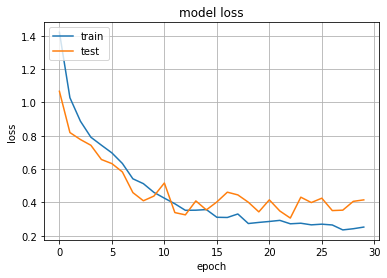

In [270]:
score = model4.evaluate(X_test, Y_test)
print('\n')
print('-'*100)
print('\n')
print(f'model accuracy is {score[1]}')

import matplotlib.pyplot  as plt
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [271]:
# Initiliazing the sequential model
model4_1 = Sequential()
# Configuring the parameters
model4_1.add(LSTM(8, input_shape=(timesteps, input_dim),return_sequences= True))
# Adding a dropout layer
model4_1.add(Dropout(0.3))
model4_1.add(BatchNormalization())

model4_1.add(LSTM(16,return_sequences= True))
model4_1.add(Dropout(0.5))
model4_1.add(BatchNormalization())

model4_1.add(LSTM(32))
model4_1.add(Dropout(0.7))
model4_1.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model4_1.add(Dense(n_classes, activation='sigmoid'))
model4_1.summary()

# Compiling the model
model4_1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 128, 8)            576       
_________________________________________________________________
dropout_68 (Dropout)         (None, 128, 8)            0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 128, 8)            32        
_________________________________________________________________
lstm_79 (LSTM)               (None, 128, 16)           1600      
_________________________________________________________________
dropout_69 (Dropout)         (None, 128, 16)           0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 128, 16)           64        
_________________________________________________________________
lstm_80 (LSTM)               (None, 32)              

In [272]:
model4_1.load_weights('model4.hdf5')

# Compiling the model
model4_1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [274]:
score = model4_1.evaluate(X_train, Y_train)
print('\n')
print('-'*100)
print('\n')
print(f'model accuracy is {score[1]}')

230/230 [==============================] - 6s 28ms/step - loss: 0.1911 - accuracy: 0.9482


----------------------------------------------------------------------------------------------------


model accuracy is 0.9481773376464844


In [277]:
# Initiliazing the sequential model
model5 = Sequential()
# Configuring the parameters
model5.add(LSTM(16, input_shape=(timesteps, input_dim),return_sequences= True))
# Adding a dropout layer
model5.add(Dropout(0.3))
model5.add(BatchNormalization())

model5.add(LSTM(32,return_sequences= True))
model5.add(Dropout(0.5))
model5.add(BatchNormalization())

model5.add(LSTM(64))
model5.add(Dropout(0.7))
model5.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes, activation='sigmoid'))
model5.summary()

# Compiling the model
model5.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 128, 16)           1664      
_________________________________________________________________
dropout_74 (Dropout)         (None, 128, 16)           0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 128, 16)           64        
_________________________________________________________________
lstm_85 (LSTM)               (None, 128, 32)           6272      
_________________________________________________________________
dropout_75 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 128, 32)           128       
_________________________________________________________________
lstm_86 (LSTM)               (None, 64)              

In [281]:
filepath = "model5.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')

# Training the model
history5=model5.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_split=0.33,
          epochs=epochs,
          callbacks=[checkpoint])

Epoch 1/30
308/308 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8960
Epoch 00001: val_accuracy improved from -inf to 0.92048, saving model to model5.hdf5
308/308 [==============================] - 55s 178ms/step - loss: 0.3002 - accuracy: 0.8960 - val_loss: 0.3959 - val_accuracy: 0.9205
Epoch 2/30
308/308 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.9129
Epoch 00002: val_accuracy improved from 0.92048 to 0.92419, saving model to model5.hdf5
308/308 [==============================] - 53s 171ms/step - loss: 0.2605 - accuracy: 0.9129 - val_loss: 0.3494 - val_accuracy: 0.9242
Epoch 3/30
308/308 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.9131
Epoch 00003: val_accuracy improved from 0.92419 to 0.92707, saving model to model5.hdf5
308/308 [==============================] - 52s 170ms/step - loss: 0.2778 - accuracy: 0.9131 - val_loss: 0.3488 - val_accuracy: 0.9271
Epoch 4/30
308/308 [=============================

In [282]:
# Confusion Matrix
print(confusion_matrix(Y_test, model5.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                 2
SITTING                  1      436  ...                   0                 0
STANDING                 0      151  ...                   0                 0
WALKING                  0        0  ...                  18                 0
WALKING_DOWNSTAIRS       0        0  ...                 417                 2
WALKING_UPSTAIRS         0        0  ...                   4               455

[6 rows x 6 columns]


93/93 [==============================] - 3s 37ms/step - loss: 0.3429 - accuracy: 0.9084


----------------------------------------------------------------------------------------------------


model accuracy is 0.9083814024925232


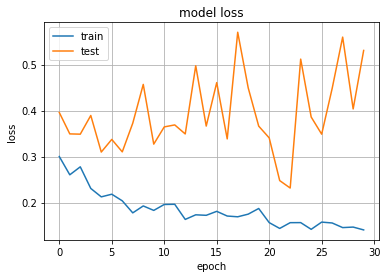

In [283]:
score = model5.evaluate(X_test, Y_test)
print('\n')
print('-'*100)
print('\n')
print(f'model accuracy is {score[1]}')

import matplotlib.pyplot  as plt
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [285]:
# Initiliazing the sequential model
model5_1 = Sequential()
# Configuring the parameters
model5_1.add(LSTM(16, input_shape=(timesteps, input_dim),return_sequences= True))
# Adding a dropout layer
model5_1.add(Dropout(0.3))
model5_1.add(BatchNormalization())

model5_1.add(LSTM(32,return_sequences= True))
model5_1.add(Dropout(0.5))
model5_1.add(BatchNormalization())

model5_1.add(LSTM(64))
model5_1.add(Dropout(0.7))
model5_1.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model5_1.add(Dense(n_classes, activation='sigmoid'))
model5_1.summary()

# Compiling the model
model5_1.load_weights('model5.hdf5')

# Compiling the model
model5_1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 128, 16)           1664      
_________________________________________________________________
dropout_80 (Dropout)         (None, 128, 16)           0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 128, 16)           64        
_________________________________________________________________
lstm_91 (LSTM)               (None, 128, 32)           6272      
_________________________________________________________________
dropout_81 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 128, 32)           128       
_________________________________________________________________
lstm_92 (LSTM)               (None, 64)              

In [286]:
score = model5_1.evaluate(X_test, Y_test)
print('\n')
print('-'*100)
print('\n')
print(f'model accuracy is {score[1]}')

93/93 [==============================] - 4s 39ms/step - loss: 0.3214 - accuracy: 0.9328


----------------------------------------------------------------------------------------------------


model accuracy is 0.9328130483627319


In [289]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "architecture", "Test Accuracy"]
x.add_row(["1", "LSTM(8+16)", "70.00%"])
x.add_row(["2", "LSTM(16+32)","90.91%"])
x.add_row(["3", "LSTM(32+64)","92.23%"])
x.add_row(["4", "LSTM(8+16+32)","94.82%"])
x.add_row(["5", "LSTM(16+32+64)","93.28%"])
print(x)

+-------+----------------+---------------+
| S.NO. |  architecture  | Test Accuracy |
+-------+----------------+---------------+
|   1   |   LSTM(8+16)   |     70.00%    |
|   2   |  LSTM(16+32)   |     90.91%    |
|   3   |  LSTM(32+64)   |     92.23%    |
|   4   | LSTM(8+16+32)  |     94.82%    |
|   5   | LSTM(16+32+64) |     93.28%    |
+-------+----------------+---------------+
